In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv
/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv


## Preparing data

In [2]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis='columns',inplace=True)
df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


((5572, 2), None)

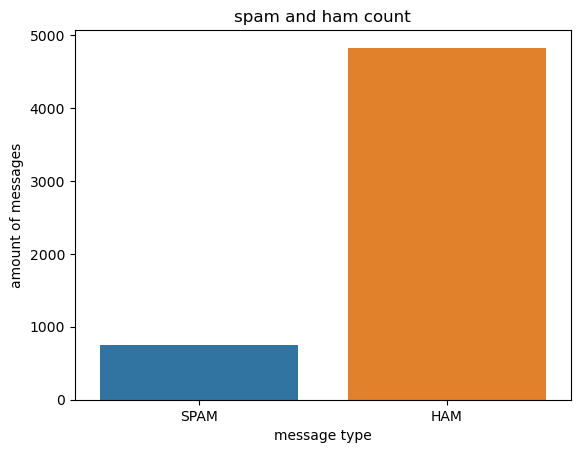

In [4]:
msg_cnts = [df[df['v1']=='spam'].shape[0],df[df['v1']=='ham'].shape[0]]
x_label=['SPAM','HAM']
sns.barplot(x=x_label, y=msg_cnts)
plt.title("spam and ham count")
plt.xlabel("message type")
plt.ylabel("amount of messages")
plt.show()

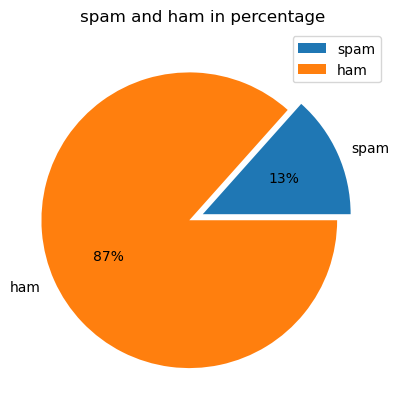

In [5]:
labels = ["spam","ham"]
plt.pie(x=msg_cnts,explode = [0,0.1],labels=labels,autopct='%.0f%%')
plt.title("spam and ham in percentage")
plt.legend()
plt.show()

## Imbalance dataset Handling
>Here from this graph it is easily identical it is imbalanced dataset, so to make it balanced we are adding new dataset into this notebook.

In [6]:
def unlabeler(lis):
    temp = []
    for dp in lis:
        if dp == 0:
            temp.append('ham')
        else:
            temp.append('spam')
    return temp

new1 = pd.read_csv("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
new1_df = new1[new1['label']=='spam']
new2 = pd.read_csv("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
new2_df = new2[new2['label']==1]

# first dataframe
new_df = new1_df.drop(["Unnamed: 0",'label_num'],axis='columns')
new_df.columns = df.columns

# second dataframe
new2_df['v1'] = unlabeler(new2_df['label'])
new2_df['v2'] = new2['email']
new2_df = new2_df.drop(['email','label'],axis='columns')
new2_df.head()

/tmp/ipykernel_20/971541448.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new2_df['v1'] = unlabeler(new2_df['label'])
/tmp/ipykernel_20/971541448.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new2_df['v2'] = new2['email']


,v1,v2
2500,spam,save up to NUMBER on life insurance why spend...
2501,spam,NUMBER fight the risk of cancer URL NUMBER sli...
2502,spam,NUMBER fight the risk of cancer URL NUMBER sli...
2503,spam,adult club offers free membership instant acc...
2504,spam,i thought you might like these NUMBER slim dow...


In [7]:
new_df.head()

,v1,v2
3,spam,"Subject: photoshop , windows , office . cheap ..."
7,spam,Subject: looking for medication ? we ` re the ...
10,spam,Subject: vocable % rnd - word asceticism\r\nvc...
11,spam,Subject: report 01405 !\r\nwffur attion brom e...
13,spam,Subject: vic . odin n ^ ow\r\nberne hotbox car...


In [8]:
balanced_df = pd.concat([df,new_df,new2_df],axis='rows')
balanced_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df = balanced_df.copy()
df.isnull().sum(),df.shape

(v1    0
 v2    1
 dtype: int64,
 (7571, 2))

In [10]:
df.dropna(inplace=True)

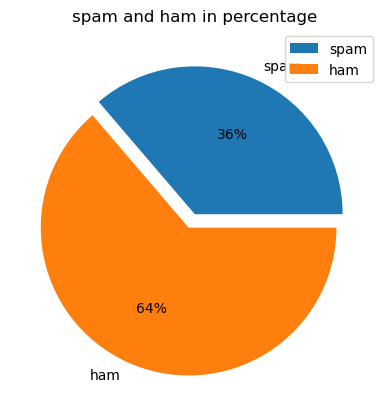

In [11]:
msg_cnts = [df[df['v1']=='spam'].shape[0],df[df['v1']=='ham'].shape[0]]
labels = ["spam","ham"]
plt.pie(x=msg_cnts,explode = [0,0.1],labels=labels,autopct='%.0f%%')
plt.title("spam and ham in percentage")
plt.legend()
plt.show()

## Natural Language Processing
here we need to precess v2 data column and column v1 can be processed with just labeling it. <br><br>
**1)Text Processing**
* getting data <br>
* replacing brackets from text with blank space <br>
* url removing from text data <br>
* removing words starts with @ <br>
* row html removing <br>
* removing non character and non number data <br>
* word lowering 
* word tokenization <br>
* white spaces removing <br>
* stopwords removing <br>
* lemmatization / stemming <br>

**2)Word cloud visualization** <br>
**3)Vectorization** <br>
* BOW (bag of word) <br>
* TF-IDF (term frequency - inverse document frequency)


In [12]:
import nltk
import re
from urllib.parse import urlparse
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings('ignore')

In [13]:
nltk.download('omw-1.4') # Open Multilingual Wordnet, this is an lexical database 
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### --> 1) Text Processing

In [15]:
def textPocess(sms):
    try:
        # brackets replacing by space
        sms = re.sub('[][)(]',' ',sms)

        # url removing
        sms = [word for word in sms.split() if not urlparse(word).scheme]
        sms = ' '.join(sms)

        # removing words starts from @
        sms = re.sub(r'\@\w+','',sms)

        # removing html tags 
        sms = re.sub(re.compile("<.*?>"),'',sms)
        
        # getting only characters and numbers
        sms = re.sub('[^A-Za-z0-9]',' ',sms)
        
        # make all words into lowercase
        sms = sms.lower()
        
        # word tokennization 
        tokens = word_tokenize(sms,language='english')
        
        # removing whitespaces
        sms = [word.strip() for word in tokens]
        
        # removing word and number combinations or numbers
#         sms = [word for word in sms if not re.search('\d.',word)]
        
        # stopwords removing
        sms = [word for word in sms if word not in stop_words]
        
        # lemmatization
        sms = [lemmatizer.lemmatize(word) for word in sms]
        sms = ' '.join(sms)
        
        return sms
    except Exception as e:
        print("sms",sms)
        print("Error",e)
        return 0

In [16]:
df['processed'] = df['v2'].apply(lambda sms: textPocess(sms))

In [17]:
encoder = LabelEncoder()
df['encoded'] = encoder.fit_transform(df['v1'])
df.head()

,v1,v2,processed,encoded
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though,0


### --> 2) Word cloud

In [18]:
from wordcloud import WordCloud
spam_df = df[df['v1']=='spam']
ham_df = df[df['v1']=='ham']

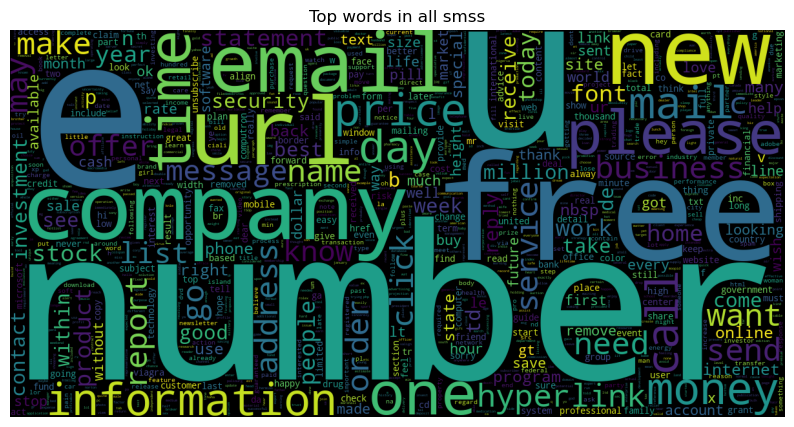

In [19]:
wc = WordCloud(background_color = "black", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

text_data = [data for data in df['processed']]
text_data = ' '.join(text_data)
wc.generate(text_data)
plt.figure(figsize=[10,7])
plt.title("Top words in all smss")
plt.imshow(wc)
plt.axis('off')
plt.show()

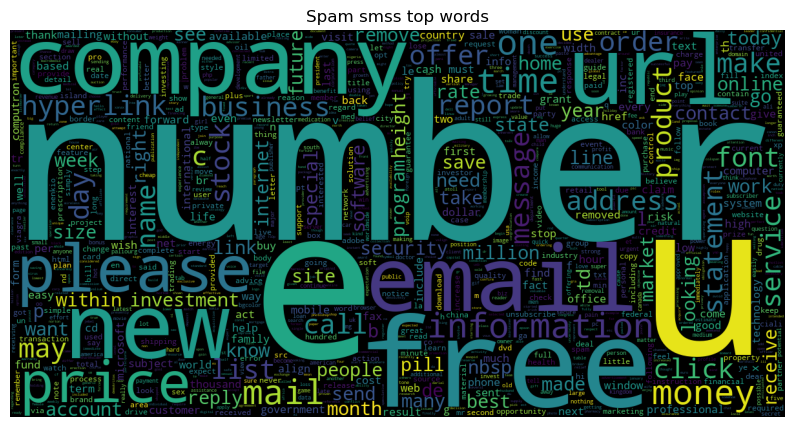

In [20]:
text_data = [data for data in spam_df['processed']]
text_data = ' '.join(text_data)
wc.generate(text_data)
plt.figure(figsize=[10,7])
plt.title("Spam smss top words")
plt.imshow(wc)
plt.axis('off')
plt.show()

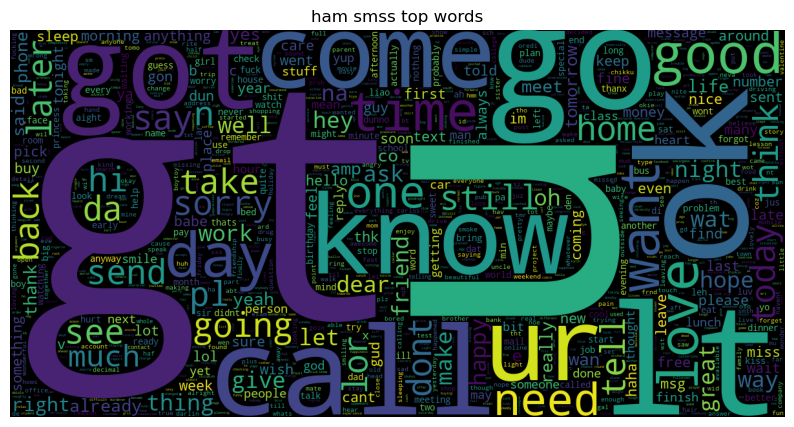

In [21]:
text_data = [data for data in ham_df['processed']]
text_data = ' '.join(text_data)
wc.generate(text_data)
plt.figure(figsize=[10,7])
plt.title("ham smss top words")
plt.imshow(wc)
plt.axis('off')
plt.show()

### --> 3) Vectorizing words from smss
* Bag of Words
* TF-IDF (term frequency - inverse document frequency)

#### ----> Bag of Words

In [22]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
MIN_DF = 10

In [23]:
bow_vec = CountVectorizer(min_df=MIN_DF)
bow_vec_class = bow_vec.fit_transform(df['processed'])
bow_vec_arr = bow_vec_class.toarray()
bow_df = pd.DataFrame(bow_vec_arr,columns=bow_vec.get_feature_names_out())
bow_df.head()

,00,000,01,02,0200,03,04,05,0500,06,...,yup,zealand,zenith,zero,zimbabwe,zip,zone,zonedubai,zyban,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### ----> TF-IDF

In [24]:
tf_vec = TfidfVectorizer(min_df=MIN_DF)
tf_vec_class = tf_vec.fit_transform(df['processed'])
tf_vec_arr = tf_vec_class.toarray()
tf_df = pd.DataFrame(tf_vec_arr,columns=tf_vec.get_feature_names_out())
tf_df.head()

,00,000,01,02,0200,03,04,05,0500,06,...,yup,zealand,zenith,zero,zimbabwe,zip,zone,zonedubai,zyban,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
tf_df.shape,bow_df.shape,df.shape

((7570, 3476), (7570, 3476), (7570, 4))

## Model Building

In [26]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

In [27]:
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(bow_df,df['encoded'],stratify=df['encoded'])
X_train_t,X_test_t,y_train_t,y_test_t = train_test_split(tf_df,df['encoded'],stratify=df['encoded'])
print("X_train_b.shape,y_test_b.shape",X_train_b.shape,y_test_b.shape)
print("X_train_t.shape,y_test_t.shape",X_train_t.shape,y_test_t.shape)

X_train_b.shape,y_test_b.shape (5677, 3476) (1893,)
X_train_t.shape,y_test_t.shape (5677, 3476) (1893,)


#### ----> training on BOW dataframe (Naive Bayes)

In [28]:
model_nb_ber = BernoulliNB()
model_nb_ber.fit(X_train_b,y_train_b)
model_nb_ber.score(X_test_b,y_test_b)

0.8679344955097729

#### ----> training on TF-IDF dataframe (Naive Bayes)

In [29]:
model_nb_ber = BernoulliNB()
model_nb_ber.fit(X_train_t,y_train_t)
model_nb_ber.score(X_test_t,y_test_t)

0.8578975171685156

In [30]:
bag_cv_score = cross_val_score(BernoulliNB(),bow_df,df['encoded'])
tf_cv_score = cross_val_score(BernoulliNB(),tf_df,df['encoded'])
print("score for BOW",bag_cv_score,"average",sum(bag_cv_score)/len(bag_cv_score))
print("score for tf-idf",tf_cv_score,"average",sum(tf_cv_score)/len(tf_cv_score))

score for BOW [0.64332893 0.81902246 0.89299868 0.90951123 0.95046235] average 0.8430647291941875
score for tf-idf [0.64332893 0.81902246 0.89299868 0.90951123 0.95046235] average 0.8430647291941875


#### ----> training on BOW dataframe (Logistic Regression)

In [31]:
model_nb_ber = LogisticRegression()
model_nb_ber.fit(X_train_b,y_train_b)
model_nb_ber.score(X_test_b,y_test_b)

0.9646064447966192

In [32]:
bag_cv_score = cross_val_score(LogisticRegression(),bow_df,df['encoded'])
tf_cv_score = cross_val_score(LogisticRegression(),tf_df,df['encoded'])
print("score for BOW",bag_cv_score,"average",sum(bag_cv_score)/len(bag_cv_score))
print("score for tf-idf",tf_cv_score,"average",sum(tf_cv_score)/len(tf_cv_score))

score for BOW [0.93923382 0.94055482 0.94319683 0.94649934 0.97424042] average 0.9487450462351387
score for tf-idf [0.89630119 0.92998679 0.91545575 0.92073976 0.94583884] average 0.9216644649933949


#### ----> training on TF-IDF dataframe (Logistic Regression)

In [33]:
model_nb_ber = LogisticRegression()
model_nb_ber.fit(X_train_t,y_train_t)
model_nb_ber.score(X_test_t,y_test_t)

0.9535129424194401

In [34]:
# final training model
model = LogisticRegression()
model.fit(tf_df,df['encoded'])

LogisticRegression()

## Real SMS testing from my mobile

In [35]:
def textProcess(sms):
    try:
        # brackets replacing by space
        sms = re.sub('[][)(]',' ',sms)

        # url removing
        sms = [word for word in sms.split() if not urlparse(word).scheme]
        sms = ' '.join(sms)

        # removing words starts from @
        sms = re.sub(r'\@\w+','',sms)

        # removing html tags 
        sms = re.sub(re.compile("<.*?>"),'',sms)
        
        # getting only characters and numbers
        sms = re.sub('[^A-Za-z0-9]',' ',sms)
        
        # make all words into lowercase
        sms = sms.lower()
        
        # word tokennization 
        tokens = word_tokenize(sms,language='english')
        
        # removing whitespaces
        sms = [word.strip() for word in tokens]
        
#         # removing word and number combinations or numbers
#         sms = [word for word in sms if not re.search('\d.',word)]
        
        # stopwords removing
        sms = [word for word in sms if word not in stop_words]
        
        # lemmatization
        sms = [lemmatizer.lemmatize(word) for word in sms]
        sms = ' '.join(sms)
        
        return sms
    except Exception as e:
        print("sms",sms)
        print("Error",e)
        return 0
    
def manager(sms):
    sms = textProcess(sms)
    sms = tf_vec.transform([sms])
    result = model.predict(sms)
    return result

In [36]:
sms1 = """100% of daily 1.50 GB data quota exhausted as on 26-May-23 00:31. 
Jio Number : Daily high speed data quota will be restored on 26-May-23 01:04.
To know where you have consumed your data quota, click """

sms2 = """Hurry! Recharge Jio no.XXXXXXXXXX on PhonePe & get rewards upto Rs.500 
each on first 3 recharges for self & family. Recharge with Rs.239 plan .T&CA. 
Click https://phon.pe/jion1"""

sms3 = """Hi XXXXXXXXX,
Prize pool - Rs. 5,00,00,000 (5 Cr)
Rs. 8850* Bonus on Junglee Rummy.
Win Now - http://gmg.im/fZBPBl To Optout SMS JR to 56161"""

sms4 = """Hello Player,
SANDEEP Won Rs.8,16,000 on Howzat!
MI vs LSG is Live. 
Play and win from Rs.60 lakhs
Entry Fees - Rs.34
Click - http://gmg.im/fq9U93"""

sms5 = """1 day left! Participate in Coding Ninjas 100% Scholarship Test. 
Get up to 100% Scholarship on all courses. Register now weurl.co/4s7rMG
- Coding Ninjas"""

sms6 = """IDBI Bank A/c  credited for INR 92.00 thru UPI. 
Bal INR 1136.68 (incl. of chq in clg) as of 25 MAY 19:46hr. If not used by you, call """

sms7 = """Your a/c no. is debited for Rs.100.00 on 20-05-23 and credited to a/c no. 
(UPI Ref no ).To block UPI services of IDBI Bank, 
Send SMS as UPIBLOCK <type your mobile no> to  from your registered number, 
or call immediately.- IDBI BANK"""

sms8 = """IDBI Bank A/c NN13554 credited for INR 10.00 thru UPI. Bal INR 15649.68 
(incl. of chq in clg) as of 14 MAY 10:26hr. If not used by you, call """

sms9 = """Enter the word or phrase you want to replace in Find what. 
Enter your new text in Replace with. """

sms10 = """Dear Customer, +XXXXXXXX is now available to take calls."""
sms_lis = [sms1,sms2,sms3,sms4,sms5,sms6,sms7,sms8,sms9,sms10]

In [37]:
for i,sms in enumerate(sms_lis):
    res = manager(sms)
    print("sms "+str(i+1),res)

sms 1 [1]
sms 2 [1]
sms 3 [1]
sms 4 [1]
sms 5 [0]
sms 6 [0]
sms 7 [1]
sms 8 [0]
sms 9 [1]
sms 10 [0]


## My profile
If you are interested you can visit my LinkedIn profile and connect I just want big network <br>
LinkedIn = https://www.linkedin.com/in/vijay-takbhate-b9231a236